<a href="https://colab.research.google.com/github/AnirbanMukherjeeXD/face-recognition-using-vggface/blob/main/face_recognition_using_vggface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition

Recognize celebrity faces using VGG-Face.

## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import cv2
from google.colab.patches import cv2_imshow

In [3]:
!pip install keras_applications

     |████████████████████████████████| 51kB 7.0MB/s 


In [4]:
import tensorflow as tf
import keras_applications
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from scipy.spatial.distance import cosine

We use pretrained model VGG-Face for creating face embeddings.

In [5]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-ztaxb_3h
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-ztaxb_3h
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp37-none-any.whl size=8312 sha256=b5bc0fdd5e87fed58705c12952f3ba64aff720e372dd63656769c9ec84111e21
  Stored in directory: /tmp/pip-ephem-wheel-cache-wb5eh6xj/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [6]:
from keras_vggface.vggface import VGGFace

## Extracting and preparing the dataset

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d hereisburak/pins-face-recognition --unzip

 96% 355M/372M [00:01<00:00, 287MB/s]
100% 372M/372M [00:01<00:00, 248MB/s]


In [9]:
classes=os.listdir('105_classes_pins_dataset')

We take the first 20 classes.

In [33]:
classes

['pins_Johnny Depp',
 'pins_Madelaine Petsch',
 'pins_Morena Baccarin',
 'pins_Tuppence Middleton',
 'pins_kiernen shipka',
 'pins_Natalie Dormer',
 'pins_Emilia Clarke',
 'pins_barbara palvin',
 'pins_ellen page',
 'pins_Pedro Alonso',
 'pins_Bobby Morley',
 'pins_Jessica Barden',
 'pins_amber heard',
 'pins_Danielle Panabaker',
 'pins_Rami Malek',
 'pins_Jimmy Fallon',
 'pins_Keanu Reeves',
 'pins_Hugh Jackman',
 'pins_margot robbie',
 'pins_Amanda Crew',
 'pins_Alex Lawther',
 'pins_Richard Harmon',
 'pins_Dwayne Johnson',
 'pins_alycia dabnem carey',
 'pins_Brie Larson',
 'pins_Tom Cruise',
 'pins_barack obama',
 'pins_elizabeth olsen',
 'pins_Inbar Lavi',
 'pins_Brian J. Smith',
 'pins_Ursula Corbero',
 'pins_Robert Downey Jr',
 'pins_elon musk',
 'pins_Brenton Thwaites',
 'pins_Gwyneth Paltrow',
 'pins_Tom Hardy',
 'pins_melissa fumero',
 'pins_Wentworth Miller',
 'pins_Megan Fox',
 'pins_Rihanna',
 'pins_Stephen Amell',
 'pins_Chris Pratt',
 'pins_Anthony Mackie',
 'pins_Shakira

In [10]:
classes_lim=20

Now we create X which stores the images resized into 224,224 dimensions.

We also create Y which stores the output labels encoded into numbers from 0 to 19.

In [61]:
classes[:10]

['pins_Johnny Depp',
 'pins_Madelaine Petsch',
 'pins_Morena Baccarin',
 'pins_Tuppence Middleton',
 'pins_kiernen shipka',
 'pins_Natalie Dormer',
 'pins_Emilia Clarke',
 'pins_barbara palvin',
 'pins_ellen page',
 'pins_Pedro Alonso']

In [11]:
X=[]
Y=[]

IMG_SIZE=224

for i in range(classes_lim):
  class_i=os.listdir('105_classes_pins_dataset/'+classes[i])
  print('105_classes_pins_dataset/'+classes[i])
  for j in class_i:
    img=cv2.imread('105_classes_pins_dataset/'+classes[i]+'/'+j)
    # X.append(cv2.resize(img, (100, 100)))
    if(len(X)==0):
      X=cv2.resize(img, (IMG_SIZE, IMG_SIZE))
      X=X.reshape(1,X.shape[0],X.shape[1],X.shape[2])
    else:  
      X=np.append(X,[cv2.resize(img, (IMG_SIZE, IMG_SIZE))],axis=0)
    Y.append(i)

Y=np.array(Y)

105_classes_pins_dataset/pins_Johnny Depp
105_classes_pins_dataset/pins_Madelaine Petsch
105_classes_pins_dataset/pins_Morena Baccarin
105_classes_pins_dataset/pins_Tuppence Middleton
105_classes_pins_dataset/pins_kiernen shipka
105_classes_pins_dataset/pins_Natalie Dormer
105_classes_pins_dataset/pins_Emilia Clarke
105_classes_pins_dataset/pins_barbara palvin
105_classes_pins_dataset/pins_ellen page
105_classes_pins_dataset/pins_Pedro Alonso
105_classes_pins_dataset/pins_Bobby Morley
105_classes_pins_dataset/pins_Jessica Barden
105_classes_pins_dataset/pins_amber heard
105_classes_pins_dataset/pins_Danielle Panabaker
105_classes_pins_dataset/pins_Rami Malek
105_classes_pins_dataset/pins_Jimmy Fallon
105_classes_pins_dataset/pins_Keanu Reeves
105_classes_pins_dataset/pins_Hugh Jackman
105_classes_pins_dataset/pins_margot robbie
105_classes_pins_dataset/pins_Amanda Crew


Let's view some of the faces.

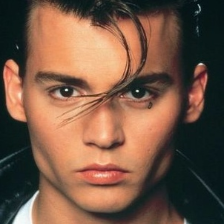

In [14]:
cv2_imshow(X[120])

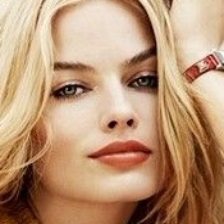

In [13]:
cv2_imshow(X[3135])

## Importing face recognition model

In [15]:
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

94699520/94694792 [==============================] - 1s 0us/step


Now we generate the embedding correspoinding to all the images.

In [16]:
face_Y=model.predict(X)

## Using Cosine distance as metric

Cosine distance is used to measure the similarity between two non-zero vectors.

Less value of cosine distance means the vectors are similar.

### Same class

In [22]:
score = cosine(face_Y[90], face_Y[91])
print(score)

0.26425987482070923


### Different class

In [18]:
score = cosine(face_Y[0], face_Y[400])
print(score)

0.731381356716156


## Dimension Reduction using PCA

In [23]:
face_Y.shape

(3431, 2048)

We can see that the embeddings vectors have 2048 dimensions. 

We reduce the dimensions into 100 using PCA.

In [88]:
pca=PCA(n_components=2000)
X_pca=pca.fit_transform(face_Y)

In [89]:
X_pca.shape

(3431, 2000)

We split the data into 80% for training and 20% for testing data. 

In [90]:
X_train, X_test, Y_train, Y_test=train_test_split(X_pca,Y,test_size=0.2,random_state=42)

## SVM

We build a support vector machine. 

Since this is multiclass classification, we use 'one-versus-one' approach.

In [91]:
svm=SVC(decision_function_shape='ovo')
svm.fit(X_train,Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [84]:
accuracy_score(Y_train,svm.predict(X_train))

1.0

In [85]:
accuracy_score(Y_test,svm.predict(X_test))

0.9912663755458515

We can see that for both training and testing data we get around 99% accuracy.

## Custom example

Writing a function to print the celebrity name from a given image path.

In [86]:
def predict_celeb(img_path):
  new_img=cv2.imread(img_path)
  X=cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))
  X=X.reshape(1,X.shape[0],X.shape[1],X.shape[2])
  X=model.predict(X)
  X=pca.transform(X)

  cv2_imshow(cv2.resize(new_img,(IMG_SIZE,int(new_img.shape[0]*IMG_SIZE/new_img.shape[1]))))
  print(classes[svm.predict(X)[0]].replace("pins_",""))

Testing this function on some random screenshots taken from movies.

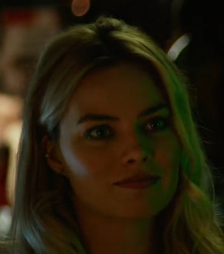

margot robbie


In [74]:
predict_celeb('mr.png')

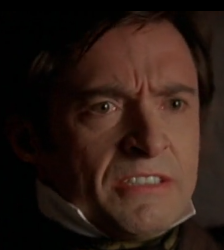

Hugh Jackman


In [99]:
predict_celeb('hj.png')